In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import sys
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Hyperparameter configurations
exp_num = -1     # To save the result, change every time. -1 to not save.
num_epochs = 10
learning_rate = 0.01
dropout_prob = 0.5

if exp_num!=-1: os.mkdir(f'./Result{exp_num}')

In [10]:
# Weight Dropout Layer
class WeightDropout(nn.Module):
    def __init__(self, module, p=0.5):
        super(WeightDropout, self).__init__()
        self.module = module
        self.p = p
        self.weight = nn.Parameter(module.weight.data)

    def forward(self, *args):
        if self.training:
            # weights after dropout
            weight = F.dropout(self.weight, p=self.p, training=True)
            # assign new weights to self.module.weight
            self.module.weight = nn.Parameter(weight)
        return self.module(*args)

# ***Basic Code***

In [11]:
def dataset_MNIST():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader

def dataset_FMNIST():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.2860,), (0.3530,))])
  train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader

def dataset_CIFAR10():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
  train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader

def dataset_CIFAR100():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
  train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
  test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader

In [12]:
# Model training function
def Run(num_epochs, dataset, method):
  # Choose dataset
  if dataset=='MNIST': train_loader, test_loader = dataset_MNIST()
  elif dataset=='FMNIST': train_loader, test_loader = dataset_FMNIST()
  elif dataset=='CIFAR-10': train_loader, test_loader = dataset_CIFAR10()
  elif dataset=='CIFAR-100': train_loader, test_loader = dataset_CIFAR100()

  # Save log
  if exp_num!=-1:
    sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'w')
    sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'a')

  model.to(device)
  train_acc_list = []
  test_acc_list = []
  train_loss_list = []
  test_loss_list = []
  
  for epoch in range(num_epochs):
      # Train
      model.train()
      train_loss, train_correct = 0, 0
      for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
      train_loss /= len(train_loader.dataset)
      train_accuracy = train_correct / len(train_loader.dataset)
      train_acc_list.append(train_accuracy)
      train_loss_list.append(train_loss)

      # Test
      model.eval()
      test_loss, test_correct = 0, 0
      with torch.no_grad():
          for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
          test_loss /= len(test_loader.dataset)
          test_accuracy = test_correct / len(test_loader.dataset)
          test_acc_list.append(test_accuracy)
          test_loss_list.append(test_loss)

      # Show Result
      print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.8f} | Train Accuracy: {round(train_accuracy*100, 6):.6f} | '
            f'Test Loss: {test_loss:.8f} | Test Accuracy: {round(test_accuracy*100, 6):.6f}')

  return train_loss_list, train_acc_list, test_loss_list, test_acc_list

In [13]:
# 그래프
def plot(dataset, method, exp_num):
    figname = f"[{dataset}] {method}  #{exp_num}.svg"
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Test_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Test_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if exp_num != -1 : plt.savefig(f'./Result{exp_num}/'+figname, format='svg')
    plt.show()

# ***Experiments***

## 1) [MNIST] VGG-like ND

In [14]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Model
model = Net_MNIST()

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'NoDrop')

Epoch  1 | Train Loss: 0.01379333 | Train Accuracy: 75.275000 | Test Loss: 0.00298730 | Test Accuracy: 93.900000
Epoch  2 | Train Loss: 0.00189967 | Train Accuracy: 96.296667 | Test Loss: 0.00144928 | Test Accuracy: 97.100000
Epoch  3 | Train Loss: 0.00115693 | Train Accuracy: 97.733333 | Test Loss: 0.00120372 | Test Accuracy: 97.460000
Epoch  4 | Train Loss: 0.00084896 | Train Accuracy: 98.335000 | Test Loss: 0.00102569 | Test Accuracy: 97.790000
Epoch  5 | Train Loss: 0.00066042 | Train Accuracy: 98.713333 | Test Loss: 0.00091521 | Test Accuracy: 98.070000
Epoch  6 | Train Loss: 0.00052142 | Train Accuracy: 99.016667 | Test Loss: 0.00084337 | Test Accuracy: 98.220000
Epoch  7 | Train Loss: 0.00041303 | Train Accuracy: 99.268333 | Test Loss: 0.00080862 | Test Accuracy: 98.310000
Epoch  8 | Train Loss: 0.00032638 | Train Accuracy: 99.421667 | Test Loss: 0.00077528 | Test Accuracy: 98.350000
Epoch  9 | Train Loss: 0.00025570 | Train Accuracy: 99.560000 | Test Loss: 0.00078501 | Test Acc

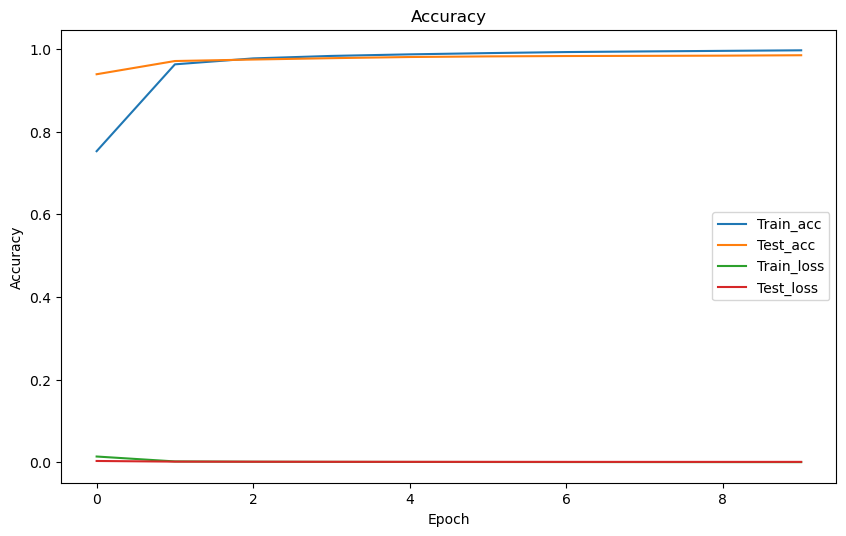

In [15]:
plot('MNIST', 'NoDrop', exp_num)

## 2) [MNIST] VGG-like Drop

In [16]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# Initialize model
model = Net_MNIST()

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'Drop')

Epoch  1 | Train Loss: 0.01537303 | Train Accuracy: 67.855000 | Test Loss: 0.00287862 | Test Accuracy: 94.140000
Epoch  2 | Train Loss: 0.00242705 | Train Accuracy: 95.228333 | Test Loss: 0.00155073 | Test Accuracy: 96.770000
Epoch  3 | Train Loss: 0.00156297 | Train Accuracy: 96.921667 | Test Loss: 0.00112925 | Test Accuracy: 97.540000
Epoch  4 | Train Loss: 0.00121361 | Train Accuracy: 97.580000 | Test Loss: 0.00088345 | Test Accuracy: 98.050000
Epoch  5 | Train Loss: 0.00100078 | Train Accuracy: 97.943333 | Test Loss: 0.00076750 | Test Accuracy: 98.310000
Epoch  6 | Train Loss: 0.00086121 | Train Accuracy: 98.248333 | Test Loss: 0.00068239 | Test Accuracy: 98.580000
Epoch  7 | Train Loss: 0.00075935 | Train Accuracy: 98.495000 | Test Loss: 0.00065654 | Test Accuracy: 98.620000
Epoch  8 | Train Loss: 0.00066100 | Train Accuracy: 98.675000 | Test Loss: 0.00058322 | Test Accuracy: 98.700000
Epoch  9 | Train Loss: 0.00062195 | Train Accuracy: 98.775000 | Test Loss: 0.00055396 | Test Acc

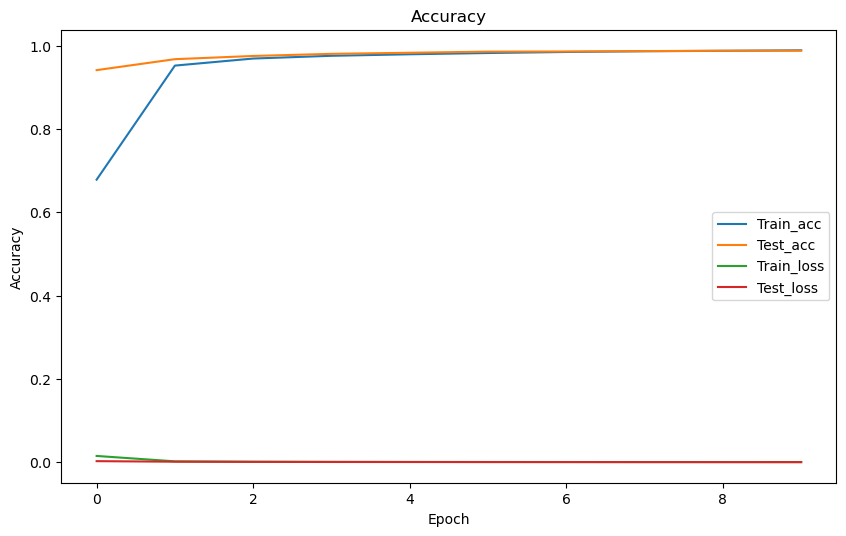

In [17]:
plot('MNIST', 'Drop', exp_num)

## 3) [MNIST] VGG-like WD

In [18]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(4*4*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Initialize model
model = Net_MNIST()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'WeightDrop')

Epoch  1 | Train Loss: 0.03437327 | Train Accuracy: 22.940000 | Test Loss: 0.01971379 | Test Accuracy: 52.910000
Epoch  2 | Train Loss: 0.00910287 | Train Accuracy: 81.508333 | Test Loss: 0.00467287 | Test Accuracy: 90.820000
Epoch  3 | Train Loss: 0.00427538 | Train Accuracy: 91.533333 | Test Loss: 0.00336388 | Test Accuracy: 93.100000
Epoch  4 | Train Loss: 0.00321537 | Train Accuracy: 93.668333 | Test Loss: 0.00274351 | Test Accuracy: 94.460000
Epoch  5 | Train Loss: 0.00272468 | Train Accuracy: 94.563333 | Test Loss: 0.00225771 | Test Accuracy: 95.210000
Epoch  6 | Train Loss: 0.00237137 | Train Accuracy: 95.310000 | Test Loss: 0.00254033 | Test Accuracy: 94.810000
Epoch  7 | Train Loss: 0.00218133 | Train Accuracy: 95.630000 | Test Loss: 0.00191913 | Test Accuracy: 96.100000
Epoch  8 | Train Loss: 0.00201751 | Train Accuracy: 95.965000 | Test Loss: 0.00180904 | Test Accuracy: 96.140000
Epoch  9 | Train Loss: 0.00184799 | Train Accuracy: 96.305000 | Test Loss: 0.00178351 | Test Acc

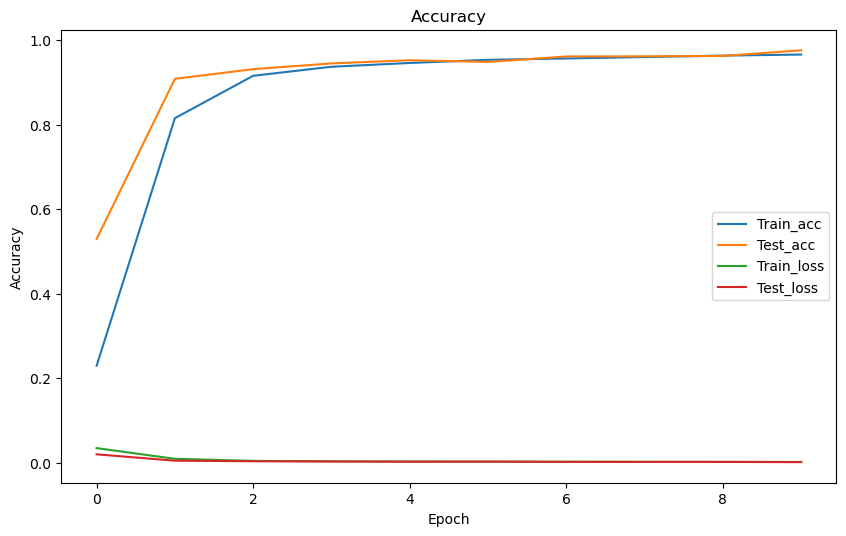

In [19]:
plot('MNIST', 'WD', exp_num)

## 1) [FMNIST] VGG-like NoD

In [20]:
class Net_FMNIST(nn.Module):
    def __init__(self):
        super(Net_FMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = Net_FMNIST()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'FMNIST', 'NoDrop')

Epoch  1 | Train Loss: 0.02001482 | Train Accuracy: 58.701667 | Test Loss: 0.01190310 | Test Accuracy: 69.700000
Epoch  2 | Train Loss: 0.00997665 | Train Accuracy: 75.658333 | Test Loss: 0.00911607 | Test Accuracy: 78.210000
Epoch  3 | Train Loss: 0.00815103 | Train Accuracy: 80.153333 | Test Loss: 0.00809344 | Test Accuracy: 80.130000
Epoch  4 | Train Loss: 0.00714601 | Train Accuracy: 82.900000 | Test Loss: 0.00753189 | Test Accuracy: 81.540000
Epoch  5 | Train Loss: 0.00647629 | Train Accuracy: 84.620000 | Test Loss: 0.00711054 | Test Accuracy: 82.890000
Epoch  6 | Train Loss: 0.00597519 | Train Accuracy: 85.895000 | Test Loss: 0.00670025 | Test Accuracy: 84.140000
Epoch  7 | Train Loss: 0.00558435 | Train Accuracy: 86.771667 | Test Loss: 0.00628866 | Test Accuracy: 85.180000
Epoch  8 | Train Loss: 0.00526410 | Train Accuracy: 87.526667 | Test Loss: 0.00599141 | Test Accuracy: 85.840000
Epoch  9 | Train Loss: 0.00499285 | Train Accuracy: 88.155000 | Test Loss: 0.00574071 | Test Acc

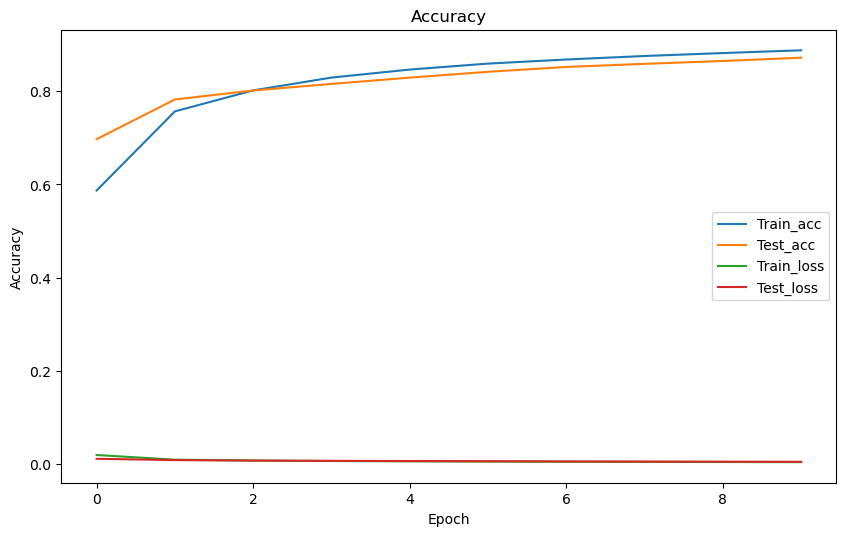

In [21]:
plot('FMNIST', 'NoDrop', exp_num)

## 2) [FMNIST] VGG-like Drop

In [22]:
class Net_FMNIST(nn.Module):
    def __init__(self):
        super(Net_FMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = Net_FMNIST()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'FMNIST', 'Drop')


Epoch  1 | Train Loss: 0.02068797 | Train Accuracy: 57.975000 | Test Loss: 0.01236906 | Test Accuracy: 69.520000
Epoch  2 | Train Loss: 0.01039439 | Train Accuracy: 74.523333 | Test Loss: 0.00954309 | Test Accuracy: 76.930000
Epoch  3 | Train Loss: 0.00858935 | Train Accuracy: 78.928333 | Test Loss: 0.00826233 | Test Accuracy: 79.700000
Epoch  4 | Train Loss: 0.00750833 | Train Accuracy: 81.811667 | Test Loss: 0.00767615 | Test Accuracy: 80.820000
Epoch  5 | Train Loss: 0.00677386 | Train Accuracy: 83.728333 | Test Loss: 0.00728703 | Test Accuracy: 81.960000
Epoch  6 | Train Loss: 0.00622011 | Train Accuracy: 85.185000 | Test Loss: 0.00682045 | Test Accuracy: 83.430000
Epoch  7 | Train Loss: 0.00577371 | Train Accuracy: 86.225000 | Test Loss: 0.00636289 | Test Accuracy: 84.760000
Epoch  8 | Train Loss: 0.00540044 | Train Accuracy: 87.055000 | Test Loss: 0.00597783 | Test Accuracy: 85.910000
Epoch  9 | Train Loss: 0.00508200 | Train Accuracy: 87.866667 | Test Loss: 0.00567473 | Test Acc

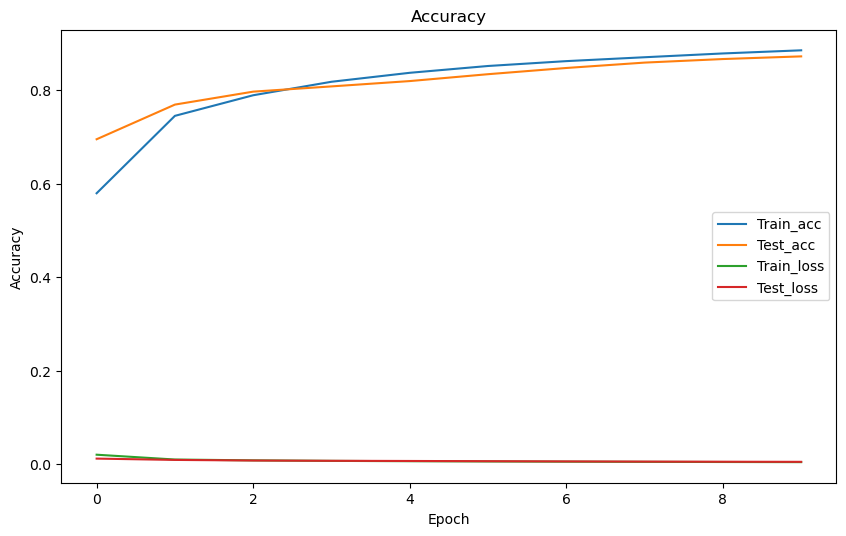

In [23]:
plot('FMNIST', 'Drop', exp_num)

## 3) [FMNIST] VGG16-like WD

In [24]:
class Net_FMNIST(nn.Module):
    def __init__(self):
        super(Net_FMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = Net_FMNIST()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'FMNIST', 'WeightDrop')

Epoch  1 | Train Loss: 0.02319717 | Train Accuracy: 54.890000 | Test Loss: 0.01354378 | Test Accuracy: 66.840000
Epoch  2 | Train Loss: 0.01044655 | Train Accuracy: 74.500000 | Test Loss: 0.00938951 | Test Accuracy: 77.470000
Epoch  3 | Train Loss: 0.00849643 | Train Accuracy: 79.278333 | Test Loss: 0.00824030 | Test Accuracy: 79.950000
Epoch  4 | Train Loss: 0.00744773 | Train Accuracy: 82.003333 | Test Loss: 0.00766873 | Test Accuracy: 81.180000
Epoch  5 | Train Loss: 0.00674127 | Train Accuracy: 83.910000 | Test Loss: 0.00727473 | Test Accuracy: 82.050000
Epoch  6 | Train Loss: 0.00620697 | Train Accuracy: 85.281667 | Test Loss: 0.00690223 | Test Accuracy: 83.440000
Epoch  7 | Train Loss: 0.00579176 | Train Accuracy: 86.325000 | Test Loss: 0.00649469 | Test Accuracy: 84.780000
Epoch  8 | Train Loss: 0.00545322 | Train Accuracy: 87.096667 | Test Loss: 0.00621543 | Test Accuracy: 85.480000
Epoch  9 | Train Loss: 0.00516872 | Train Accuracy: 87.746667 | Test Loss: 0.00597302 | Test Acc

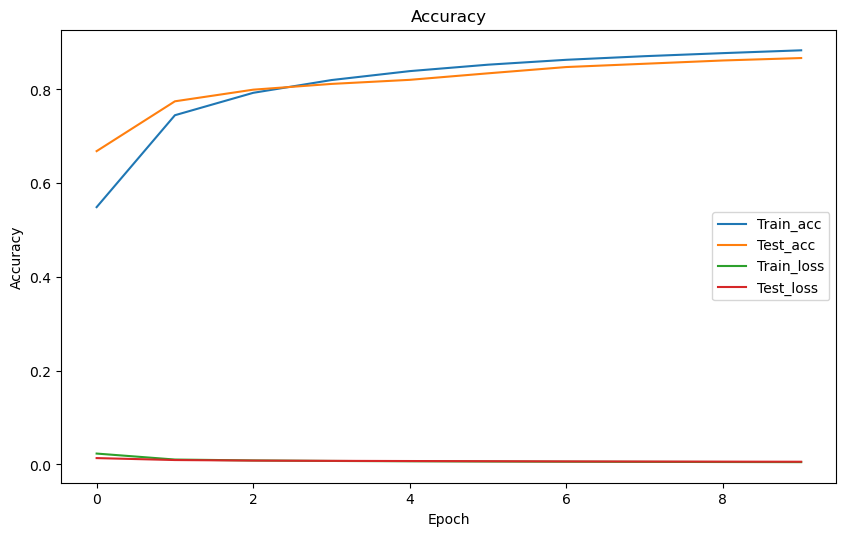

In [25]:
plot('FMNIST', 'WeightDrop', exp_num)

## 1) [CIFAR-10] VGG16-like NoD

In [26]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = Net_CIFAR10()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'NoDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.03543616 | Train Accuracy: 16.690000 | Test Loss: 0.03276660 | Test Accuracy: 22.810000
Epoch  2 | Train Loss: 0.02924645 | Train Accuracy: 32.156000 | Test Loss: 0.02838216 | Test Accuracy: 32.830000
Epoch  3 | Train Loss: 0.02553573 | Train Accuracy: 40.996000 | Test Loss: 0.02769613 | Test Accuracy: 34.720000
Epoch  4 | Train Loss: 0.02348436 | Train Accuracy: 45.856000 | Test Loss: 0.02639883 | Test Accuracy: 38.300000
Epoch  5 | Train Loss: 0.02186980 | Train Accuracy: 49.804000 | Test Loss: 0.02497461 | Test Accuracy: 42.480000
Epoch  6 | Train Loss: 0.02049422 | Train Accuracy: 53.312000 | Test Loss: 0.02470179 | Test Accuracy: 44.470000
Epoch  7 | Train Loss: 0.01924973 | Train Accuracy: 56.414000 | Test Loss: 0.02443345 | Test Accuracy: 46.250000
Epoch  8 | Train Loss: 0.01805030 | Train Accuracy: 59.384000 | Test Loss: 0.02395570 | Test Accuracy: 47.550000
Epoch  9 | Train Los

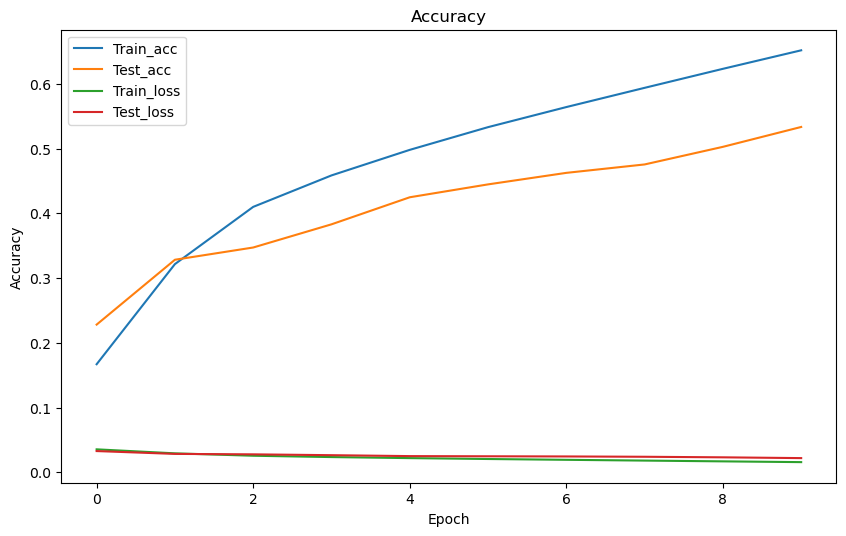

In [27]:
plot('CIFAR10', 'NoDrop', exp_num)

## 2) [CIFAR-10] VGG-like Drop

In [28]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# Initialize model
model = Net_CIFAR10()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'Drop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.03542809 | Train Accuracy: 14.470000 | Test Loss: 0.03299214 | Test Accuracy: 24.440000
Epoch  2 | Train Loss: 0.03073931 | Train Accuracy: 28.432000 | Test Loss: 0.02888776 | Test Accuracy: 32.560000
Epoch  3 | Train Loss: 0.02750550 | Train Accuracy: 36.318000 | Test Loss: 0.02619900 | Test Accuracy: 37.180000
Epoch  4 | Train Loss: 0.02504175 | Train Accuracy: 41.574000 | Test Loss: 0.02481926 | Test Accuracy: 40.910000
Epoch  5 | Train Loss: 0.02346309 | Train Accuracy: 45.600000 | Test Loss: 0.02310045 | Test Accuracy: 45.400000
Epoch  6 | Train Loss: 0.02209771 | Train Accuracy: 49.000000 | Test Loss: 0.02400077 | Test Accuracy: 44.070000
Epoch  7 | Train Loss: 0.02089888 | Train Accuracy: 51.954000 | Test Loss: 0.02438313 | Test Accuracy: 44.610000
Epoch  8 | Train Loss: 0.01986683 | Train Accuracy: 54.672000 | Test Loss: 0.02181843 | Test Accuracy: 50.070000
Epoch  9 | Train Los

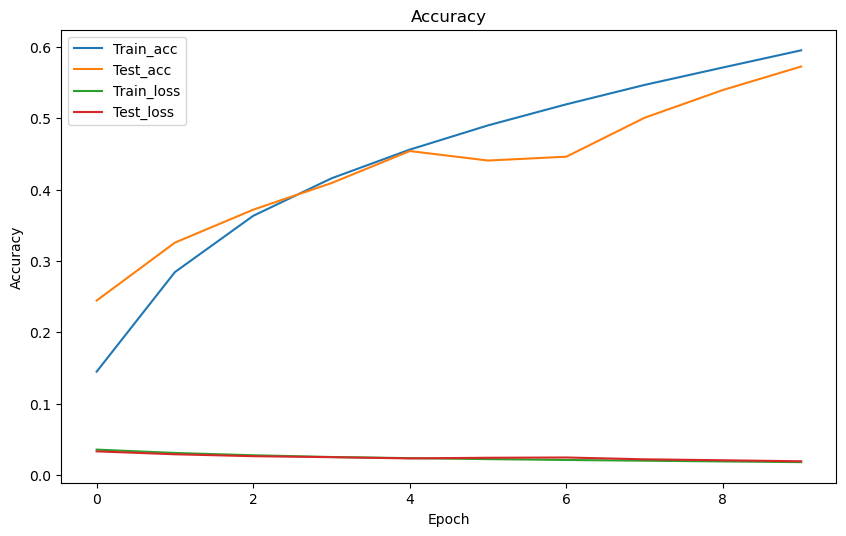

In [29]:
plot('CIFAR10', 'Drop', exp_num)

## 3) [CIFAR-10] VGG-like WD

In [30]:
class Net_CIFAR100(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(5*5*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize model
model = Net_CIFAR10()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'WeightDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.03574031 | Train Accuracy: 13.792000 | Test Loss: 0.03430255 | Test Accuracy: 21.450000
Epoch  2 | Train Loss: 0.03129416 | Train Accuracy: 26.982000 | Test Loss: 0.02909369 | Test Accuracy: 32.580000
Epoch  3 | Train Loss: 0.02758844 | Train Accuracy: 35.966000 | Test Loss: 0.02616162 | Test Accuracy: 37.330000
Epoch  4 | Train Loss: 0.02513933 | Train Accuracy: 41.048000 | Test Loss: 0.02536971 | Test Accuracy: 39.310000
Epoch  5 | Train Loss: 0.02363858 | Train Accuracy: 44.778000 | Test Loss: 0.02369608 | Test Accuracy: 43.370000
Epoch  6 | Train Loss: 0.02239594 | Train Accuracy: 48.100000 | Test Loss: 0.02357214 | Test Accuracy: 44.600000
Epoch  7 | Train Loss: 0.02122039 | Train Accuracy: 50.902000 | Test Loss: 0.02297366 | Test Accuracy: 47.070000
Epoch  8 | Train Loss: 0.02010341 | Train Accuracy: 54.106000 | Test Loss: 0.02173567 | Test Accuracy: 50.510000
Epoch  9 | Train Los

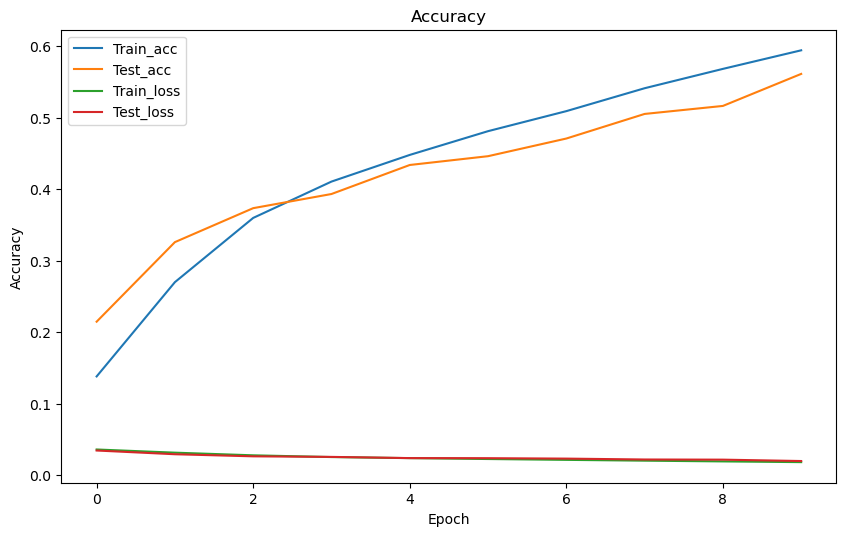

In [31]:
plot('CIFAR10', 'WD', exp_num)

## 1) [CIFAR-100] VGG16-like NoD

In [32]:
class Net_CIFAR100(nn.Module):
    def __init__(self):
        super(Net_CIFAR100, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = Net_CIFAR100()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-100', 'NoDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.07201625 | Train Accuracy: 0.932000 | Test Loss: 0.07227626 | Test Accuracy: 1.490000
Epoch  2 | Train Loss: 0.07196073 | Train Accuracy: 1.560000 | Test Loss: 0.07214041 | Test Accuracy: 1.560000
Epoch  3 | Train Loss: 0.07014451 | Train Accuracy: 2.934000 | Test Loss: 0.06682753 | Test Accuracy: 5.140000
Epoch  4 | Train Loss: 0.06204412 | Train Accuracy: 9.456000 | Test Loss: 0.06111814 | Test Accuracy: 10.320000
Epoch  5 | Train Loss: 0.05796182 | Train Accuracy: 13.808000 | Test Loss: 0.05829935 | Test Accuracy: 13.240000
Epoch  6 | Train Loss: 0.05524661 | Train Accuracy: 16.554000 | Test Loss: 0.05620978 | Test Accuracy: 15.860000
Epoch  7 | Train Loss: 0.05302339 | Train Accuracy: 19.038000 | Test Loss: 0.05483081 | Test Accuracy: 17.370000
Epoch  8 | Train Loss: 0.05102682 | Train Accuracy: 21.406000 | Test Loss: 0.05378657 | Test Accuracy: 18.730000
Epoch  9 | Train Loss: 0.04

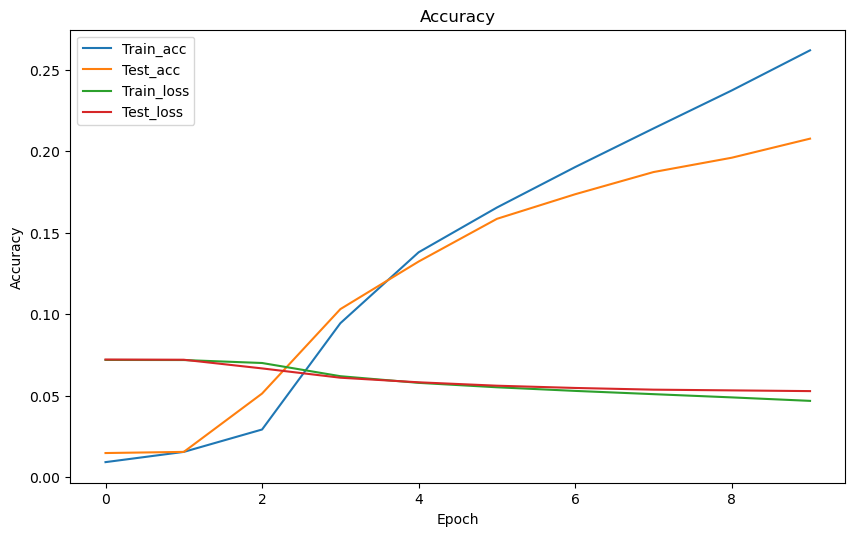

In [33]:
plot('CIFAR100', 'NoDrop', exp_num)

## 2) [CIFAR-100] VGG-like Drop

In [34]:
class Net_CIFAR100(nn.Module):
    def __init__(self):
        super(Net_CIFAR100, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# Initialize model
model = Net_CIFAR100()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-100', 'Drop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.07202338 | Train Accuracy: 1.068000 | Test Loss: 0.07229050 | Test Accuracy: 1.180000
Epoch  2 | Train Loss: 0.07200446 | Train Accuracy: 1.136000 | Test Loss: 0.07225302 | Test Accuracy: 1.840000
Epoch  3 | Train Loss: 0.07167929 | Train Accuracy: 1.412000 | Test Loss: 0.07098694 | Test Accuracy: 1.770000
Epoch  4 | Train Loss: 0.06917466 | Train Accuracy: 3.712000 | Test Loss: 0.06758718 | Test Accuracy: 5.250000
Epoch  5 | Train Loss: 0.06525816 | Train Accuracy: 6.426000 | Test Loss: 0.06323058 | Test Accuracy: 8.000000
Epoch  6 | Train Loss: 0.06234350 | Train Accuracy: 8.842000 | Test Loss: 0.06110315 | Test Accuracy: 10.240000
Epoch  7 | Train Loss: 0.06019994 | Train Accuracy: 11.068000 | Test Loss: 0.05912093 | Test Accuracy: 12.200000
Epoch  8 | Train Loss: 0.05843103 | Train Accuracy: 12.940000 | Test Loss: 0.05725195 | Test Accuracy: 14.540000
Epoch  9 | Train Loss: 0.056753

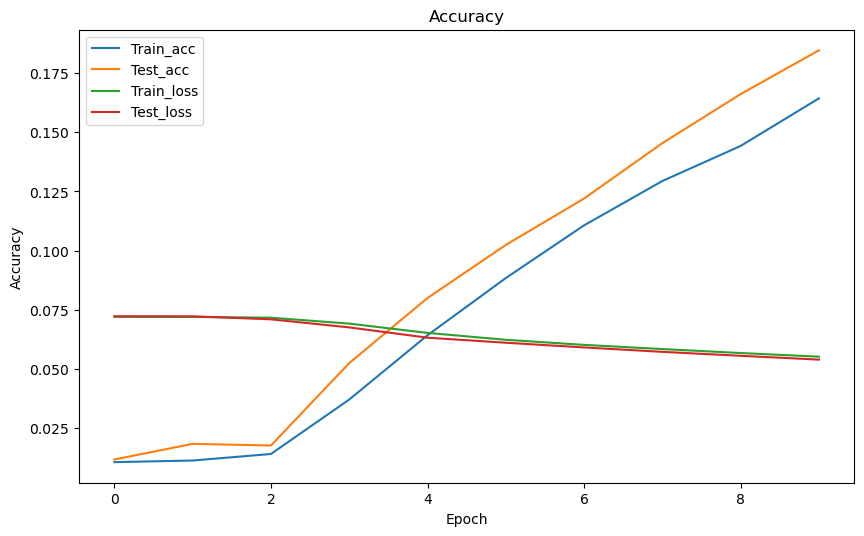

In [35]:
plot('CIFAR100', 'Drop', exp_num)

## 3) [CIFAR-100] VGG-like WD

In [36]:
class Net_CIFAR100(nn.Module):
    def __init__(self):
        super(Net_CIFAR100, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(5*5*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize model
model = Net_CIFAR100()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-100', 'WeightDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.07202369 | Train Accuracy: 0.926000 | Test Loss: 0.07229376 | Test Accuracy: 0.460000
Epoch  2 | Train Loss: 0.07201022 | Train Accuracy: 1.016000 | Test Loss: 0.07226700 | Test Accuracy: 1.190000
Epoch  3 | Train Loss: 0.07177820 | Train Accuracy: 1.110000 | Test Loss: 0.07164251 | Test Accuracy: 1.050000
Epoch  4 | Train Loss: 0.07085536 | Train Accuracy: 1.838000 | Test Loss: 0.07054778 | Test Accuracy: 2.220000
Epoch  5 | Train Loss: 0.06969693 | Train Accuracy: 2.886000 | Test Loss: 0.06982592 | Test Accuracy: 3.590000
Epoch  6 | Train Loss: 0.06879650 | Train Accuracy: 3.812000 | Test Loss: 0.06951676 | Test Accuracy: 3.620000
Epoch  7 | Train Loss: 0.06813306 | Train Accuracy: 4.528000 | Test Loss: 0.06936999 | Test Accuracy: 3.980000
Epoch  8 | Train Loss: 0.06743105 | Train Accuracy: 4.810000 | Test Loss: 0.06819273 | Test Accuracy: 4.480000
Epoch  9 | Train Loss: 0.06576719 | 

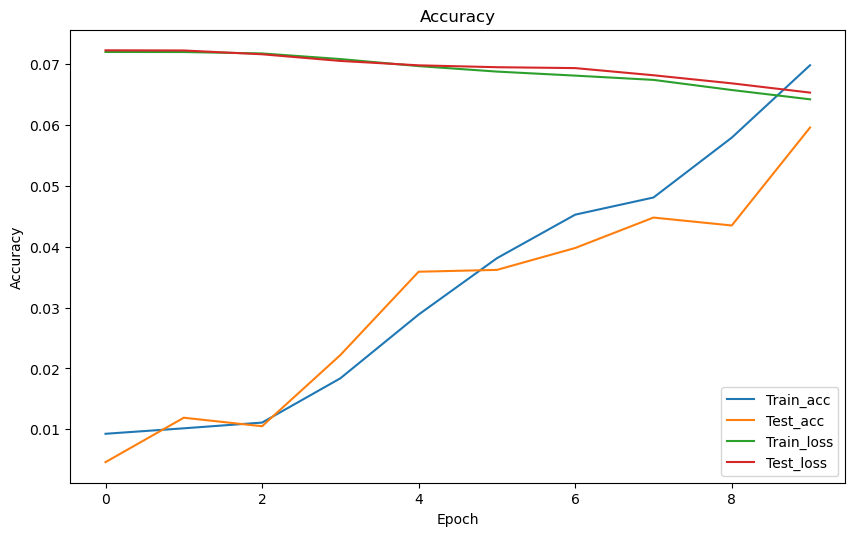

In [37]:
plot('CIFAR100', 'WD', exp_num)